# Lets work with MNIST by CNN

In [98]:
# 0) importing our needed libraries
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [99]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [93]:
# 1) loading dataset
transform = transforms.Compose([transforms.ToTensor()])
training_data = datasets.MNIST(root='./data', 
                               train=True,
                               download=True, 
                               transform=transform
                               )
training_loader = torch.utils.data.DataLoader(training_data,
                                              batch_size=100,
                                              shuffle=True
                                              )
validation_data = datasets.MNIST(root='./data', 
                                 train=False,
                                 download=True,
                                 transform=transform
                                 )
validation_loader = torch.utils.data.DataLoader(validation_data,
                                                batch_size=100,
                                                shuffle=False
                                                )

In [94]:
data_iter = iter(training_loader)
images, labels = next(data_iter)

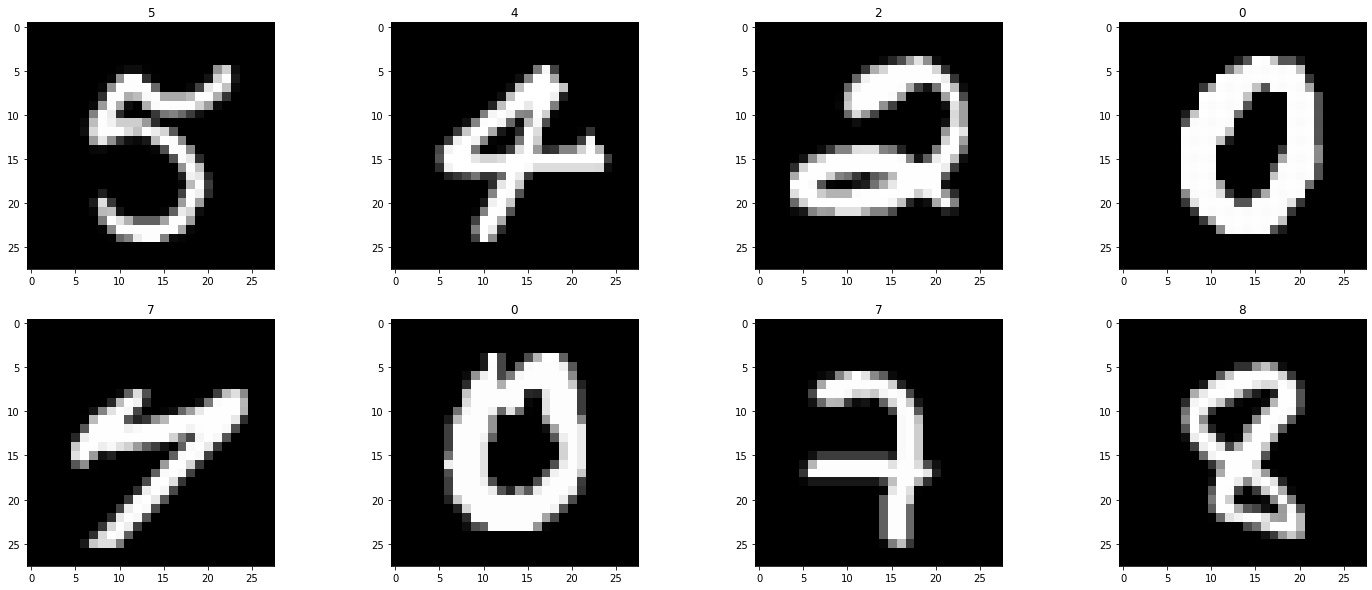

In [95]:
# 2) Showing the dataset
fig = plt.figure(figsize=(25, 10))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1)
    plt.imshow(images[idx][0], cmap='gray')
    ax.set_title(labels[idx].item())

In [96]:
# 3) Building the model 
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, (5, 5), 1)
        self.conv2 = nn.Conv2d(20, 50, (5, 5), 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout1 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
        
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [174]:
# 4) Training the model
epochs = 16
training_loss = []
training_acc = []
validation_loss = []
validation_acc = []
for e in range(epochs):
    losses = 0.0
    accuracies = 0.0
    for inputs, labels in training_loader:
        inputs.to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs.cpu(), labels)
        
        losses += loss.item()
        _, max_index = torch.max(outputs, 1)
        accuracies += torch.sum(max_index.cpu() == labels.cpu()) / labels.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    else:
        epoch_loss = losses / len(training_loader)
        training_loss.append(epoch_loss)
        epoch_acc = accuracies / len(training_loader)
        training_acc.append(epoch_acc)
        
        with torch.no_grad():
            losses = 0.0
            accuracies = 0.0
            for inputs, labels in validation_loader:
                inputs.to(device)
                outputs = model(inputs).to(device)
                loss = criterion(outputs.cpu(), labels)
                
                losses += loss.item()
                _, max_index = torch.max(outputs, 1)
                accuracies += torch.sum(max_index.cpu() == labels.cpu()) / labels.shape[0]
                
            validation_epoch_loss = losses / len(validation_loader)
            validation_loss.append(validation_epoch_loss)
            validation_epoch_acc = accuracies / len(validation_loader)
            validation_acc.append(validation_epoch_acc)
            
        print("epoch :{} , T_acc={:.4f}, T_loss={:.4f} || V_acc={:.4f}, V_loss={:.4f}".format(e, 
                                                                                              epoch_acc,
                                                                                              epoch_loss,
                                                                                              validation_epoch_acc,
                                                                                              validation_epoch_loss))
                
            

epoch :0 , T_acc=0.9979, T_loss=0.0068 || V_acc=0.9910, V_loss=0.0403
epoch :1 , T_acc=0.9984, T_loss=0.0053 || V_acc=0.9901, V_loss=0.0431
epoch :2 , T_acc=0.9981, T_loss=0.0054 || V_acc=0.9914, V_loss=0.0390
epoch :3 , T_acc=0.9978, T_loss=0.0067 || V_acc=0.9923, V_loss=0.0398
epoch :4 , T_acc=0.9984, T_loss=0.0052 || V_acc=0.9921, V_loss=0.0324
epoch :5 , T_acc=0.9982, T_loss=0.0051 || V_acc=0.9914, V_loss=0.0437
epoch :6 , T_acc=0.9985, T_loss=0.0051 || V_acc=0.9918, V_loss=0.0405
epoch :7 , T_acc=0.9980, T_loss=0.0060 || V_acc=0.9902, V_loss=0.0490
epoch :8 , T_acc=0.9976, T_loss=0.0074 || V_acc=0.9915, V_loss=0.0445
epoch :9 , T_acc=0.9985, T_loss=0.0043 || V_acc=0.9927, V_loss=0.0413
epoch :10 , T_acc=0.9989, T_loss=0.0033 || V_acc=0.9917, V_loss=0.0508
epoch :11 , T_acc=0.9988, T_loss=0.0039 || V_acc=0.9885, V_loss=0.0596
epoch :12 , T_acc=0.9986, T_loss=0.0044 || V_acc=0.9917, V_loss=0.0547
epoch :13 , T_acc=0.9982, T_loss=0.0064 || V_acc=0.9919, V_loss=0.0494
epoch :14 , T_ac

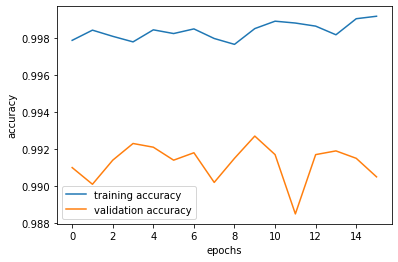

In [181]:
# 5) plot loss and acc curves
plt.plot(range(epochs), training_acc, label='training accuracy')
plt.plot(range(epochs), validation_acc, label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

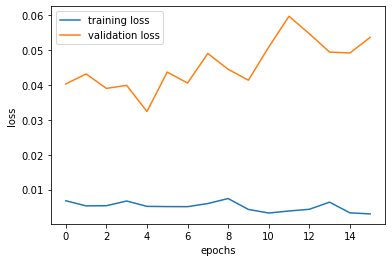

In [186]:
plt.plot(range(epochs), training_loss, label='training loss')
plt.plot(range(epochs), validation_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

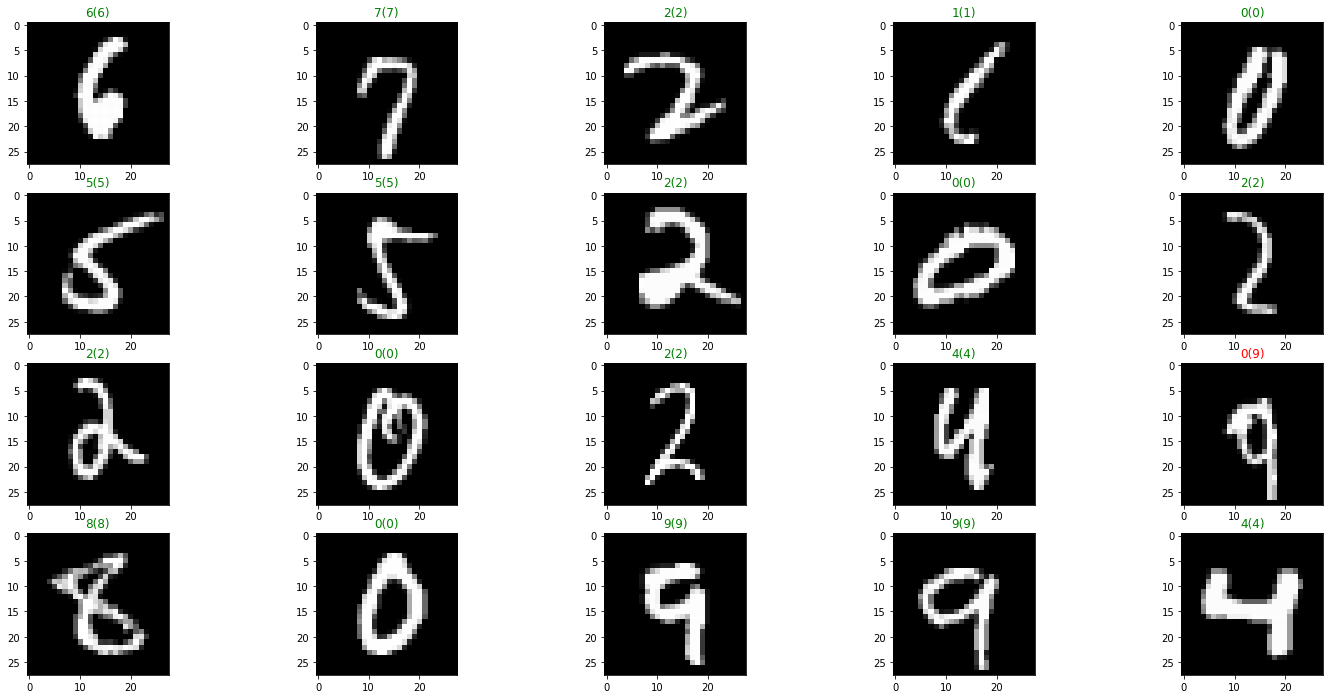

In [190]:
# 6) Check the model result 

data_iter = iter(validation_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicts = torch.max(outputs, 1)

fig = plt.figure(figsize=(25, 12))
for idx in range(20):
    ax = fig.add_subplot(4, 5, idx+1)
    plt.imshow(images[idx][0], cmap='gray')
    ax.set_title("{}({})".format(predicts[idx], labels[idx]),
                 color='green' if predicts[idx]==labels[idx] else 'red')